# Optimisation quantique avec QAOA

Dans ce notebook nous allons voir :

1) Comment préparer un **état quantique** à l'aide d'un **circuit quantique** en utilisant la classe `QuantumCircuit` de Qiskit.

2) Comment construire un **observable** en utilisant le sous-module `quantum_info` de Qiskit.

3) Comment estimer le **gain moyen** en mesurant la valeur moyenne d'un **observable** sur un **état quantique** donné.

4) À quoi ressemble un **circuit variationnel** pour **QAOA**.

5) Comment **optimiser** les paramètres d'un circuit variationnel.

6) Comment le **nombre de répétitions** dans le circuit **QAOA** influence les résultats.

7) Trouver des solutions **sans optimisation**.

## Installons quelques modules qui nous seront utiles

In [3]:
import networkx as nx

from qiskit import QuantumCircuit, generate_preset_pass_manager
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit.primitives import BackendEstimatorV2 as Estimator, BackendSamplerV2 as Sampler
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.circuit.library import PauliEvolutionGate

from scipy.optimize import minimize

In [4]:
from qaoa_utils import *

Vous devriez pouvoir éxécuter la cellule suivante si le fichier `qaoa_utils.py` se trouve dans le même dossier que ce notebook.

In [5]:
test_function()

Exercises ready!


## Préparation d'états quantiques

Commençons avec la préparation d'un état quantique en programmant un circuit quantique. Préparons l'état $|01011\rangle$.

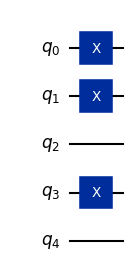

In [6]:
qc_trial_state = QuantumCircuit(5)
qc_trial_state.x([0,1,3])
qc_trial_state.draw("mpl",scale=0.75)

Nous pouvons vérifier que ce circuit prépare bien l'état désiré en simulant son éxécution à l'aide du simulateur `AerSimulator`. On utilise un `Sampler` pour échantillonner les résultats de mesure.

La prochaine cellule ajoute des mesures au circuit `qc_trial_state`, simule son éxécution et retourne un dictionnaire qui décrit quels résultats on été obtenus et combien de fois chacun (`counts`).

In [7]:
qc_trial_state_with_meas = qc_trial_state.copy()
qc_trial_state_with_meas.measure_all()

simulator = AerSimulator()
sampler = Sampler(backend=simulator) 

# On répète la préparation et la mesure du circuit 100 fois
results = sampler.run([qc_trial_state_with_meas],shots=100).result() 
counts = results[0].data.meas.get_counts()

print(f"{counts = }")

counts = {'01011': 100}


### Exercice 1

Programmer un circuit quantique qui permet de préparer l'état suivant. 

$ \frac{1}{\sqrt{2}} \big( |11101\rangle + |11001\rangle \big) $

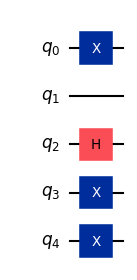

In [8]:
qc_ex_1 = QuantumCircuit(5)
qc_ex_1.x(0)
qc_ex_1.x(3)
qc_ex_1.x(4)
qc_ex_1.h(2)
qc_ex_1.draw("mpl",scale=0.75)

In [9]:
exercise_superposition_state(qc_ex_1)

Yes! Your circuit is building the right superposition


## Construire un observable

Utilisons le sous-module `quantum_info` pour construire des **observables**.

La cellule suivante illustre comment construire le premier terme de l'observable de gain associé au lien entre les noeuds rouge et orange dans le graphe des super-héros.

In [10]:
example_operator = SparsePauliOp(data=["IIIZZ"], coeffs=[-0.5])
print(example_operator)

SparsePauliOp(['IIIZZ'],
              coeffs=[-0.5+0.j])


### Exercice 2

Construisez l'opérateur de gain total pour le graphe complet du problème d'optimisation des super-héros.
$$
    - \frac{1}{2}\hat{I}\hat{I}\hat{I}\hat{Z}\hat{Z}
    - \frac{1}{2}\hat{I}\hat{I}\hat{Z}\hat{I}\hat{Z}
    - \frac{1}{2}\hat{I}\hat{I}\hat{Z}\hat{Z}\hat{I}
    - \frac{1}{2}\hat{Z}\hat{I}\hat{I}\hat{Z}\hat{I}
    - \frac{1}{2}\hat{I}\hat{Z}\hat{Z}\hat{I}\hat{I} 
    - \frac{1}{2}\hat{Z}\hat{Z}\hat{I}\hat{I}\hat{I} 
    + \frac{6}{2}\hat{I}\hat{I}\hat{I}\hat{I}\hat{I}
$$

In [13]:
a10= SparsePauliOp(data=["IIIZZ"], coeffs=[-0.5])
a20= SparsePauliOp(data=["IIZIZ"], coeffs=[-0.5])
a21 = SparsePauliOp(data=["IIZZI"], coeffs=[-0.5])
a41 = SparsePauliOp(data=["ZIIZI"], coeffs=[-0.5])
a32 = SparsePauliOp(data=["IZZII"], coeffs=[-0.5])
a43 = SparsePauliOp(data=["ZZIII"], coeffs=[-0.5])
empty = SparsePauliOp(data=["IIIII"], coeffs=[3.0])
gain_operator = a10 + a20 + a21 + a41 + a32 + a43 + empty

exercise_gain_operator(gain_operator)

Yes! This is the correct gain operator


## Estimer le gain moyen

On combine un `QuantumCircuit` et un **observable** pour **estimer le gain moyen** à l'aide de Qiskit, $  \langle\psi|\hat{G}|\psi\rangle $.

On utiliser une `Estimator` pour estimer cette valeur moyenne sur un circuit **sans mesure**.

In [12]:
data = ["IIIZZ", "IIZIZ", "IIZZI", "ZIIZI", "IZZII", "ZZIII", "IIIII"]
coeffs = [-0.5,  -0.5, -0.5, -0.5, -0.5, -0.5, 0.5*6]

gain_operator = SparsePauliOp(data=data, coeffs=coeffs)

estimator = Estimator(backend=simulator)
results = estimator.run([(qc_trial_state, gain_operator)]).result()
average_gain = float(results[0].data.evs)

print(qc_trial_state)

print(f"{average_gain = }")

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
q_4: ─────
          
average_gain = 5.0


### Exercice 3

Estimer le gain moyen à l'aide de `gain_operator` pour l'état quantique $ \frac{1}{\sqrt{2}} \big( |01011\rangle + |11011\rangle \big)$. Vous devez d'abord construire le `QuantumCircuit` qui prépare cet état.

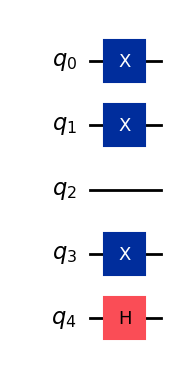

In [18]:
qc_ex_3 = QuantumCircuit(5) 
### Construisez votre circuit ici
qc_ex_3.x([0,1,3])
qc_ex_3.h(4)
qc_ex_3.draw('mpl')

In [19]:
results = estimator.run([(qc_ex_3, gain_operator)]).result()
average_gain = results[0].data.evs
exercise_average_gain(average_gain)

Yes! This is the correct circuit


## Outil de visualisation de solution

On vous fourni un outil de visualisation de solution. On doit fournir la forme du graphe comme un `Graph` de `networkx`. On doit également fournir une chaine de bits qui décrit la configuration des équipes. 

**Rappel** : Les chaines de bits se lisent de la droite vers la gauche.

L'équipe 0 apparait comme des cercles blancs, et l'équipe 1, comme des cercles gris.

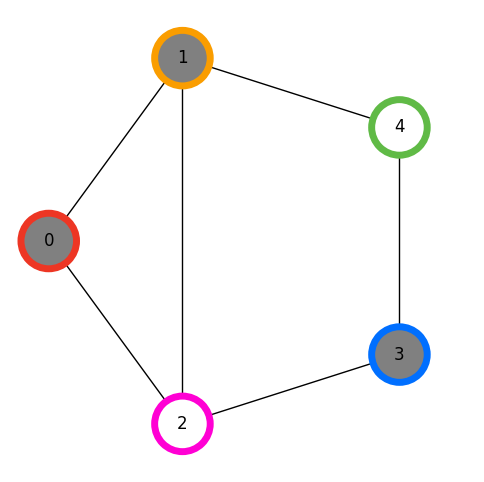

In [20]:
graph = nx.Graph()
graph.add_nodes_from([0,1,2,3,4])
graph.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 4), (2, 3), (3, 4)])

x = '01011'  # correspond à l'état `qc_trial` définit précédemment 
print_solution_graph(graph, x)

## Construction du circuit pour QAOA

L'algorithme d'optimisation approximative quantique (QAOA) utilise une forme de circuit quantique particulière. Ce circuit dépend de l'observable de **coût**, qui est la valeur **négative** de l'observable de **gain**. Il contient également des paramètres qui seront ajustés dans une routine d'optimisation.

In [21]:
cost_operator = - gain_operator
print(cost_operator)

SparsePauliOp(['IIIZZ', 'IIZIZ', 'IIZZI', 'ZIIZI', 'IZZII', 'ZZIII', 'IIIII'],
              coeffs=[ 0.5-0.j,  0.5-0.j,  0.5-0.j,  0.5-0.j,  0.5-0.j,  0.5-0.j, -3. +0.j])


1) Le circuit quantique de QAOA débute en appliquant des portes **Hadamard** sur tous les qubits pour préparer une **superposition** égale de tous les états afin d'exploiter le **parallélisme quantique**.

2) Des séries de portes **RZZ** sont ensuite appliquées en suivant la structure de l'observable de **coût**.

3) L'étape de **mélange** consiste en des rotations **RX** sur chacun des qubits.

Les étapes 2 et 3 peuvent être répétées plusieurs fois grâce au paramètre `reps`.

`Qiskit` fournit la classe `QAOAAnsatz` qui implémente cette structure. 

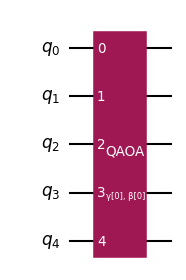

In [27]:
qaoa_ansatz_1 = QAOAAnsatz(cost_operator, reps=1)

qaoa_ansatz_1.draw('mpl', scale=0.75)

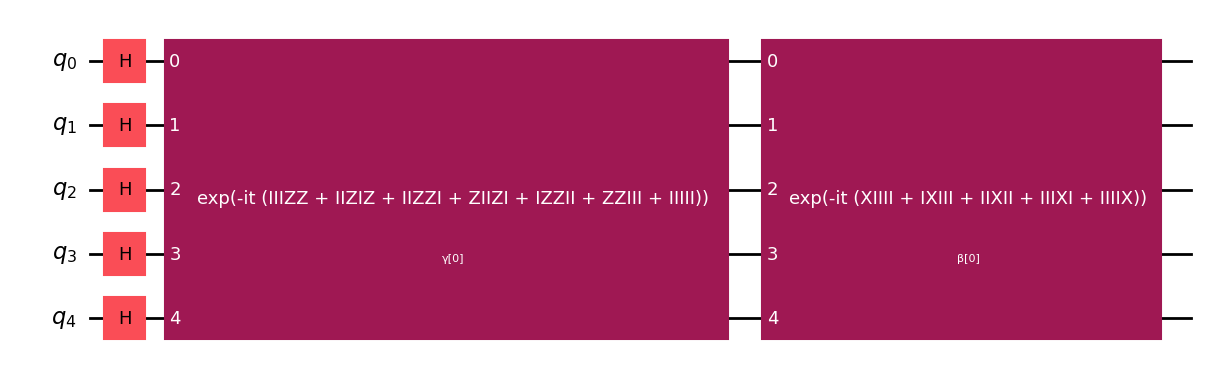

In [26]:
qaoa_ansatz_1.decompose(reps=1).draw('mpl', scale=1)

On peut spécifier les portes et le type de porte qu'on veut décomposer.

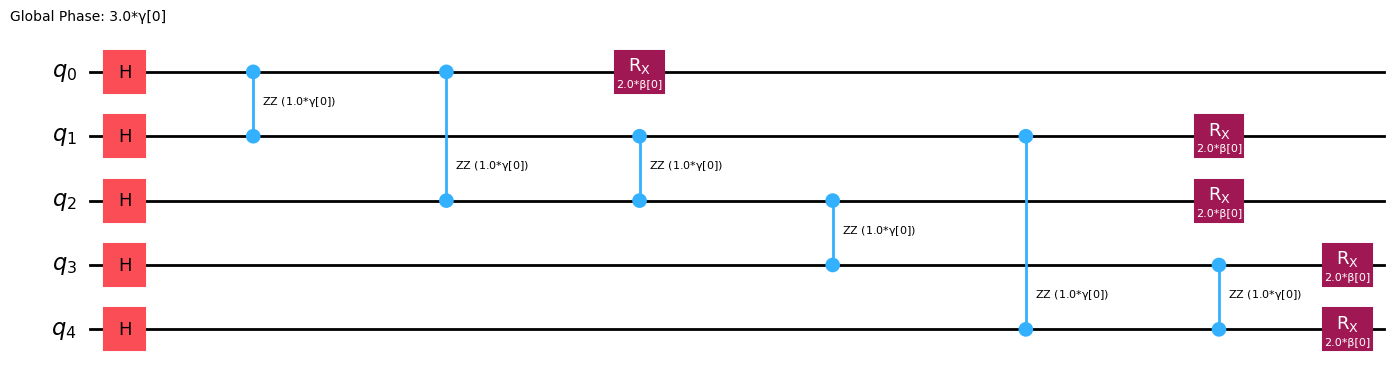

In [29]:
qaoa_ansatz_1.decompose(["QAOA", PauliEvolutionGate],reps=2).draw('mpl', scale=1)

On peut également décomposer un circuit pour qu'il soit compatible avec un `backend`.

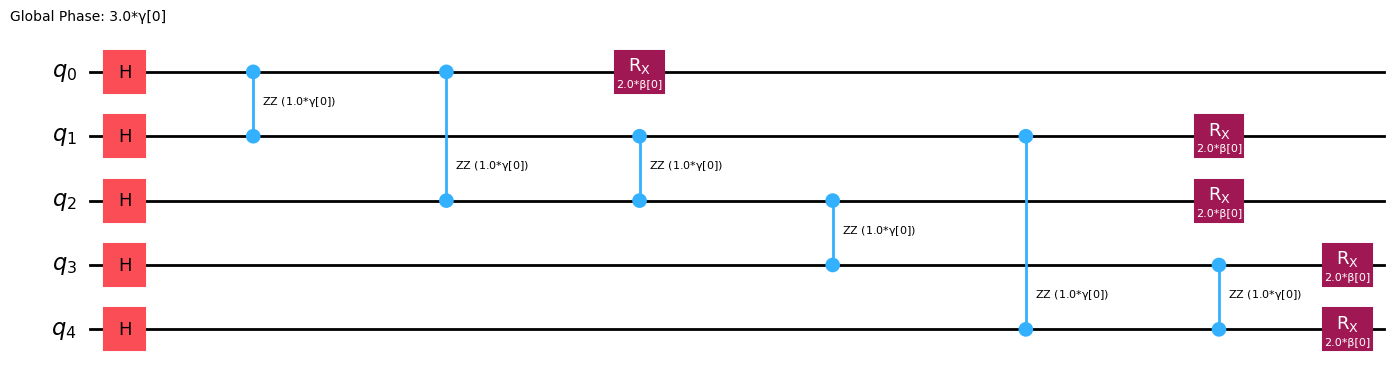

In [32]:
pass_manager = generate_preset_pass_manager(simulator)
isa_qaoa_ansatz_1 = pass_manager.run(qaoa_ansatz_1)
isa_qaoa_ansatz_1.draw("mpl",scale=1)

In [33]:
print(f"Nombre de paramètres dans le circuit: {qaoa_ansatz_1.num_parameters}")
print(qaoa_ansatz_1.parameters)

Nombre de paramètres dans le circuit: 2
ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])


# Interprétation et visualisation des résultats

L'objectif de l'algoritme QAOA est de préparer un état dont les amplitudes de probabilité les plus élevées correspondent aux solutions recherchées du problème.

On explore cet espace d'états à l'aide des paramètres du circuit QAOA.

Pour une valeur donnée des paramètres, on peut préparer et mesurer l'état correspondant plusieurs fois pour obtenir un petit nombre de solutions candidates qui pourront être vérifiées individuellement.

On présente souvent les résultats d'un calcul quantique sous la forme d'un histogramme.

In [34]:
params = np.random.random(qaoa_ansatz_1.num_parameters)
print(f"Valeur des paramètres: {params}")

isa_qaoa_ansatz_1_with_meas = isa_qaoa_ansatz_1.copy()
isa_qaoa_ansatz_1_with_meas.measure_all()

results = sampler.run([(isa_qaoa_ansatz_1_with_meas, params)]).result()
counts = results[0].data.meas.get_counts()

print(counts)

Valeur des paramètres: [0.62114699 0.51348165]
{'11101': 23, '11000': 50, '01010': 23, '11110': 38, '11111': 140, '10000': 54, '11010': 15, '11100': 22, '11001': 5, '00000': 146, '10011': 14, '10010': 15, '11011': 33, '01000': 56, '00110': 9, '10110': 17, '10111': 41, '00011': 22, '00010': 22, '01111': 46, '00001': 45, '00100': 13, '00111': 46, '01011': 16, '10001': 11, '01001': 13, '01100': 10, '10100': 14, '01101': 12, '10101': 27, '01110': 7, '00101': 19}


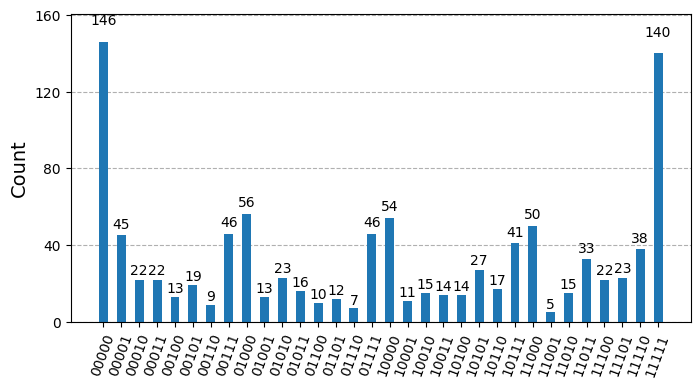

In [35]:
plot_histogram(counts, figsize=(8,4))

# Estimation de la valeur moyenne

On peut calculer la valeur moyenne de l'opérateur de coût pour l'état quantique préparé par le circuit QAOA

$  \langle\psi_\text{QAOA}(\boldsymbol{\beta},\boldsymbol{\gamma})|\hat{C}|\psi_\text{QAOA}(\boldsymbol{\beta},\boldsymbol{\gamma})\rangle $.

La classe `Estimator` de Qiskit nous permet d'estimer cette valeur moyenne.

In [36]:
estimator = Estimator(backend=simulator)

job = estimator.run([(isa_qaoa_ansatz_1, cost_operator, params)])
valeur_moyenne = job.result()[0].data.evs

print(f"Valeur moyenne: {valeur_moyenne}")

Valeur moyenne: -2.01806640625


## Optimisation des paramètres du circuit quantique de QAOA

On veut maintenant automatiser la recherche des meilleurs paramètres pour le circuit QAOA. Pour cela on doit cependant :

1) Définir la fonction à optimiser.

2) Éxécuter le processus d'optimisation avec un optimiseur classique qui choisira quels paramètres essayer dans le circuit

3) Extraire une solution comme étant l'état le plus probable.

In [37]:
# 1. Définir la fonction de coût classique à optimiser

def cost_function(
    params: list[complex], estimator: Estimator, circuit: QuantumCircuit, cost_operator: SparsePauliOp
) -> float:

    job = estimator.run([(circuit, cost_operator, params)])
    cout = job.result()[0].data.evs
    return cout

In [38]:
params_init = np.zeros(qaoa_ansatz_1.num_parameters)

# 2. Éxécuter le processus d'optimisation à l'aide de la méthode COBYLA de Scipy
res_opt = minimize(
    cost_function, params_init, args=(estimator, isa_qaoa_ansatz_1, cost_operator), method="COBYLA"
)

# 3. Extraction des informations suite à l'optimisation
cout_opt = res_opt.fun  # Cout optimal trouvé
params_opt = res_opt.x  # Paramètres optimaux trouvés

# Affichage des résultats obtenus
print("Cout optimal trouvé :", cout_opt)
print("Paramètres optimaux trouvés :", params_opt)

Cout optimal trouvé : -4.076171875
Paramètres optimaux trouvés : [1.21299671 0.78408711]


Lorsqu'on a obtenu les paramètres optimaux - c'est-à-dire ceux qui minimisent la valeur moyenne de l'observable de coût - on prépare l'état quantique correspondant et on obtient les solutions optimales.

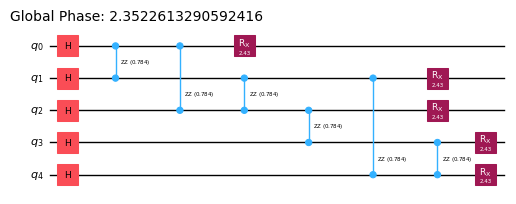

In [39]:
isa_qaoa_ansatz_1_opt = isa_qaoa_ansatz_1.assign_parameters(params_opt)
isa_qaoa_ansatz_1_opt.draw('mpl', scale=0.5)

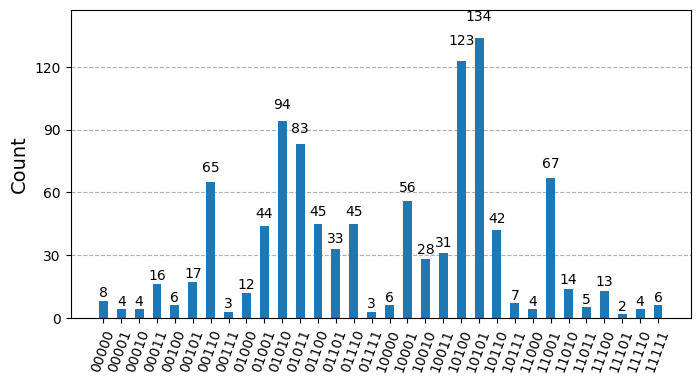

In [40]:
isa_qaoa_ansatz_1_opt.measure_all()

final_counts = simulator.run(isa_qaoa_ansatz_1_opt.decompose(reps=2)).result().get_counts()

plot_histogram(final_counts, figsize=(8,4))

In [42]:
maximum_prob_state = max(final_counts, key=final_counts.get)
print("État de base avec la plus grande probabilité: ", maximum_prob_state)

État de base avec la plus grande probabilité:  10101


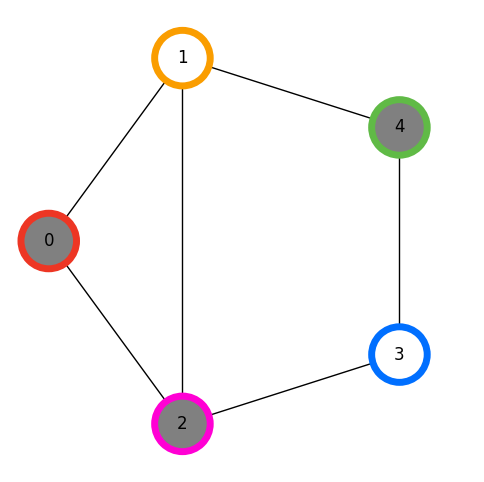

In [43]:
print_solution_graph(graph, maximum_prob_state)

### Remarque

Lorsqu'on utilise un petit nombre de répétitions, l'algorithme QAOA ne retourne pas toujours une bonne solution. Aussi, les bonnes solutions ne se distinguent pas toujours très bien des mauvaises. On va maintenant voir l'effet d'un plus grand nombre de répétitions.

## Effet du nombre de répétitions

Testons QAOA pour le même problème mais utilisons plus de répétitions.

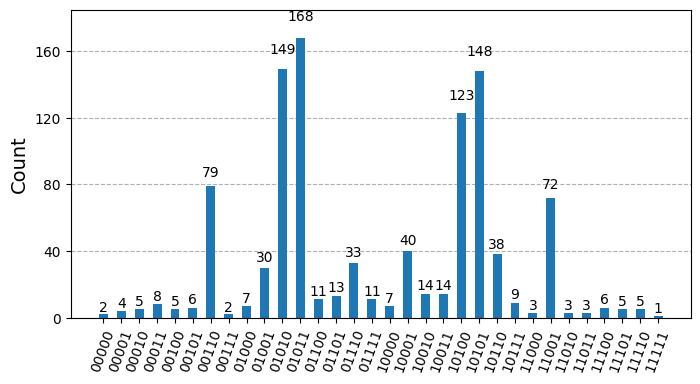

In [44]:
# Créer le circuit paramétré QAOA avec 8 répétitions
qaoa_ansatz_8 = QAOAAnsatz(cost_operator, reps=8)
isa_qaoa_ansatz_8 = pass_manager.run(qaoa_ansatz_8)

# Initialiser la valeur initiale des paramètres à 0
params_init = np.zeros(isa_qaoa_ansatz_8.num_parameters)

# Trouver la valeur des angles qui minimisent l'opérateur de coût
res_opt = minimize(
    cost_function, params_init, args=(estimator, isa_qaoa_ansatz_8, cost_operator), method="COBYLA"
)

# Extraire des informations suite à l'optimisation
cout_opt = res_opt.fun  # Coût optimal trouvé
params_opt = res_opt.x  # Paramètres optimaux trouvés

# Préparer le circuit avec des mesures
isa_qaoa_ansatz_8_with_meas = isa_qaoa_ansatz_8.copy()
isa_qaoa_ansatz_8_with_meas.measure_all()

# Échantilonner cet état
results = sampler.run([(isa_qaoa_ansatz_8_with_meas,params_opt)],shots=1024).result()
final_counts = results[0].data.meas.get_counts()

# plot the histogram
plot_histogram(final_counts, figsize=(8,4))

In [45]:
maximum_prob_state = max(final_counts, key=final_counts.get)
print("État de base avec la plus grande probabilité: ", maximum_prob_state)

État de base avec la plus grande probabilité:  01011


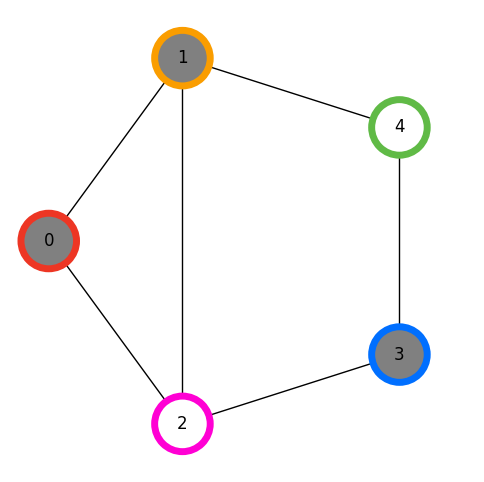

In [46]:
print_solution_graph(graph, maximum_prob_state)

## Observations

Vous remarquerez que QAOA ne converge pas sur une bonne solution à tous les coups. Cet algorithme ne s'appelle pas _Algorithme d'Optimisation **Approximative** Quantique_ pour rien!

Cependant, pour des problèmes très complexes, où le nombre de configurations possibles est exponentiellement grand, QAOA pourrait permettre de suggérer des solutions dont la validité est ensuite facile à vérifier.

# Sans optimisation

En se basant sur la théorie du recuit quantique (_quantum annealing_), il est possible de calculer classiquement un ensemble de paramètres qui permet d'obtenir une valeur moyenne qui s'approche d'un résultat optimal. Il n'est cependant pas clair si cet approche continue de fonctionner pour des systèmes de plus grande taille.

[0.25 0.5  0.75]
betas = array([-0.75, -0.5 , -0.25])
gammas = array([0.25, 0.5 , 0.75])


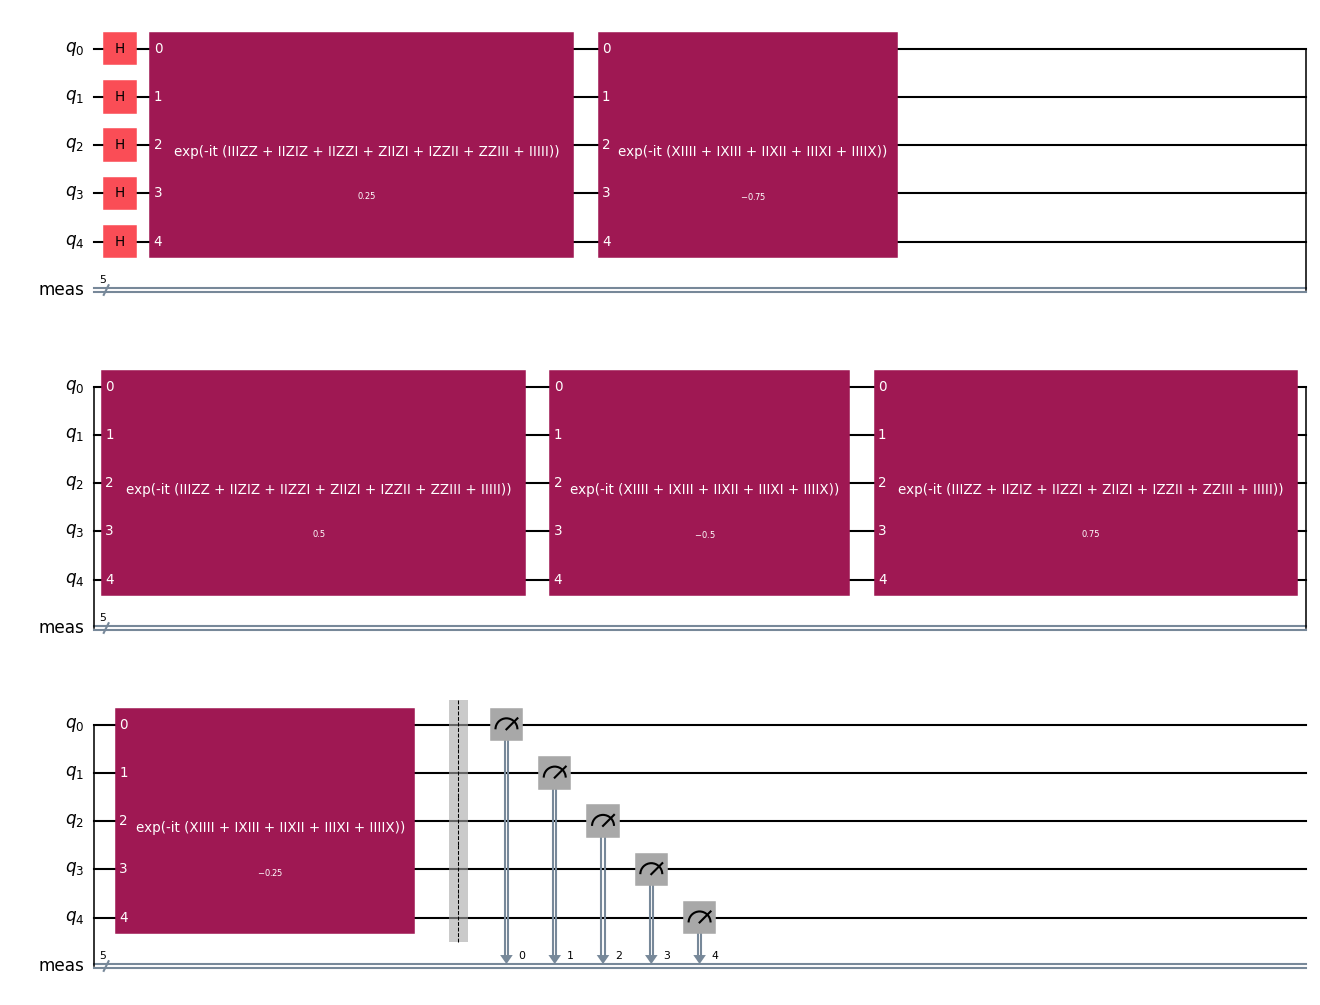

In [47]:
num_layers = 3

annealing_ansatz = QAOAAnsatz(cost_operator, reps=num_layers)

linear_ramp = np.linspace(0,1,num_layers+2)[1:-1]
print(linear_ramp)

betas = -linear_ramp[::-1]
gammas = linear_ramp

print(f"{betas = }")
print(f"{gammas = }")

annealing_circuit = annealing_ansatz.assign_parameters(np.concatenate((betas, gammas)))
annealing_circuit.measure_all()
annealing_circuit.decompose(reps=1).draw("mpl", scale=0.75)

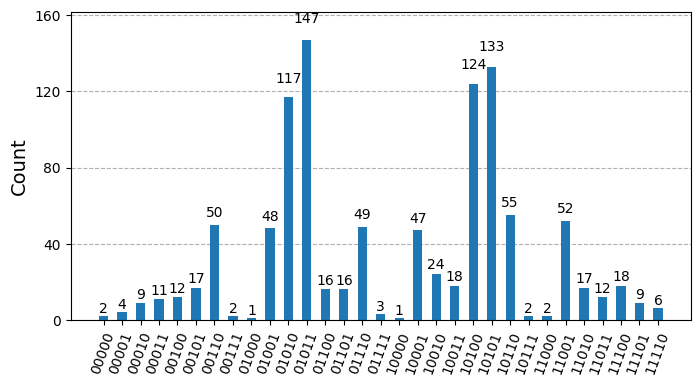

In [48]:
# Préparer un circuit compatible
isa_annealing_circuit = pass_manager.run(annealing_circuit)

# Échantilonner cet état
results = sampler.run([isa_annealing_circuit],shots=1024).result()
final_counts = results[0].data.meas.get_counts()

plot_histogram(final_counts, figsize=(8,4))